# Introduction to Weight Quantization
> Reducing the size of Large Language Models with 8-bit quantization

❤️ Created by [@maximelabonne](https://twitter.com/maximelabonne).

Companion notebook to execute the code from the following article: https://mlabonne.github.io/blog/intro_weight_quantization/

## Installation
```bash
conda create -n quantization python=3.9
pip install uv
uv pip install torch==2.5.1 torchvision==0.20.1 torchaudio==2.5.1 --index-url https://download.pytorch.org/whl/cu124
uv pip install bitsandbytes>=0.39.0
uv pip install accelerate transformers matplotlib jupyter
```

## Quantization

In [2]:
import torch

def absmax_quantize(X):
    # Calculate scale
    scale = 127 / torch.max(torch.abs(X))

    # Quantize
    X_quant = (scale * X).round()

    # Dequantize
    X_dequant = X_quant / scale

    return X_quant.to(torch.int8), X_dequant

In [3]:
def zeropoint_quantize(X):
    # Calculate value range (denominator)
    x_range = torch.max(X) - torch.min(X)
    x_range = 1 if x_range == 0 else x_range

    # Calculate scale
    scale = 255 / x_range

    # Shift by zero-point
    zeropoint = (-scale * torch.min(X) - 128).round()

    # Scale and round the inputs
    X_quant = torch.clip((X * scale + zeropoint).round(), -128, 127)

    # Dequantize
    X_dequant = (X_quant - zeropoint) / scale

    return X_quant.to(torch.int8), X_dequant

In [4]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
torch.manual_seed(0)

# Set device to CPU for now
device = 'cuda'

# Load model and tokenizer
model_id = 'Qwen/Qwen3-0.6B-Base'
model = AutoModelForCausalLM.from_pretrained(model_id, device_map='auto', dtype=torch.float16)
tokenizer = AutoTokenizer.from_pretrained(model_id)

# Print model size
print(f"Model size: {model.get_memory_footprint():,} bytes")

Model size: 1,192,100,096 bytes


In [5]:
# Extract weights of the first layer
weights = model.model.layers[0].self_attn.q_proj.weight.data
print("Original weights:")
print(weights)

# Quantize layer using absmax quantization
weights_abs_quant, _ = absmax_quantize(weights)
print("\nAbsmax quantized weights:")
print(weights_abs_quant)

# Quantize layer using absmax quantization
weights_zp_quant, _ = zeropoint_quantize(weights)
print("\nZero-point quantized weights:")
print(weights_zp_quant)

Original weights:
tensor([[ 5.8594e-03, -4.1809e-03, -1.3733e-02,  ...,  1.1169e-02,
         -5.6458e-03, -6.7139e-03],
        [-2.6367e-02,  8.8501e-03, -1.1902e-03,  ..., -3.6865e-02,
         -2.1606e-02, -8.3923e-05],
        [ 2.1973e-02,  3.2349e-03, -3.3264e-03,  ...,  1.0681e-02,
         -1.8188e-02,  2.9602e-03],
        ...,
        [ 5.7373e-02, -3.5400e-03,  1.1108e-02,  ...,  4.9072e-02,
          5.5695e-04,  4.0039e-02],
        [-1.1841e-02, -9.3994e-03,  3.1494e-02,  ..., -6.1523e-02,
          2.5024e-03,  2.3560e-02],
        [-1.0010e-01,  1.8799e-02,  2.4033e-04,  ...,  3.1494e-02,
          6.6833e-03,  8.0566e-02]], device='cuda:0', dtype=torch.float16)

Absmax quantized weights:
tensor([[  1,  -1,  -3,  ...,   2,  -1,  -1],
        [ -5,   2,   0,  ...,  -7,  -4,   0],
        [  4,   1,  -1,  ...,   2,  -3,   1],
        ...,
        [ 11,  -1,   2,  ...,   9,   0,   8],
        [ -2,  -2,   6,  ..., -12,   0,   5],
        [-19,   4,   0,  ...,   6,   1,  1

In [6]:
import numpy as np
from copy import deepcopy

# Store original weights
weights = [param.data.clone() for param in model.parameters()]

# Create model to quantize
model_abs = deepcopy(model)

# Quantize all model weights
weights_abs = []
for param in model_abs.parameters():
    _, dequantized = absmax_quantize(param.data)
    param.data = dequantized
    weights_abs.append(dequantized)

# Create model to quantize
model_zp = deepcopy(model)

# Quantize all model weights
weights_zp = []
for param in model_zp.parameters():
    _, dequantized = zeropoint_quantize(param.data)
    param.data = dequantized
    weights_zp.append(dequantized)

In [7]:
# Flatten weight tensors
weights = torch.cat([t.flatten() for t in weights]).cpu().numpy()
weights_abs = torch.cat([t.flatten() for t in weights_abs]).cpu().numpy()
weights_zp = torch.cat([t.flatten() for t in weights_zp]).cpu().numpy()

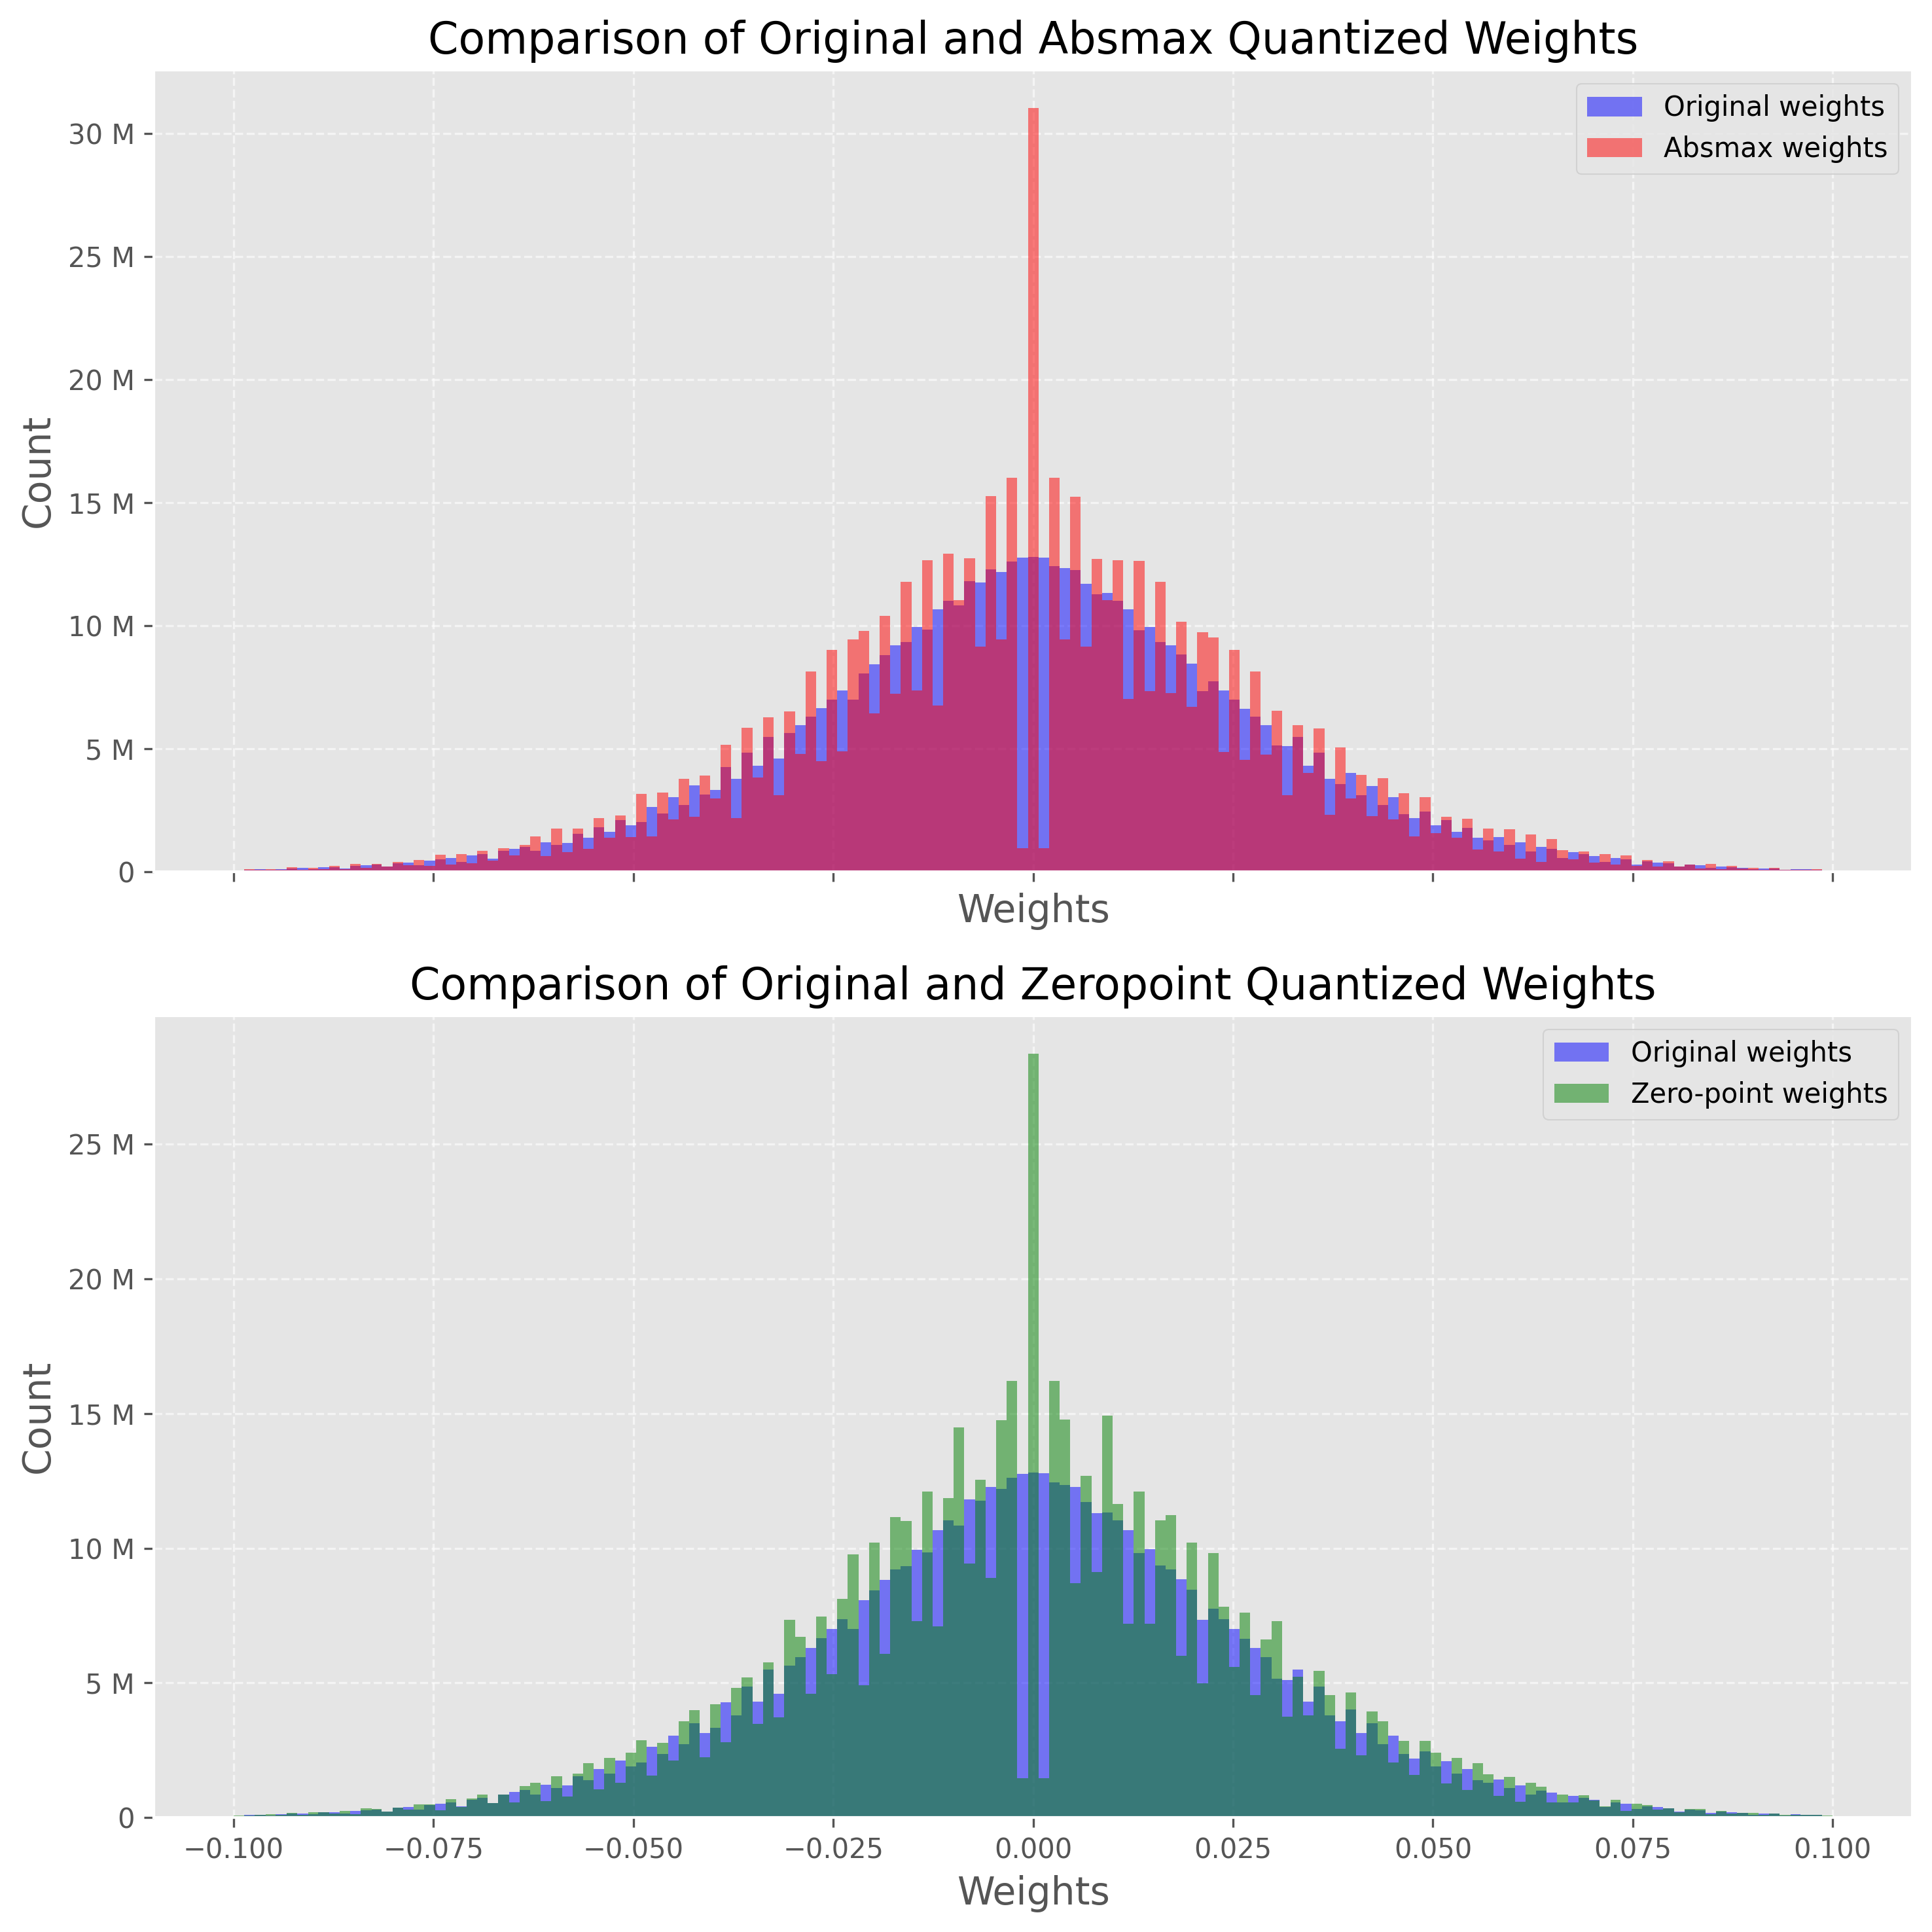

In [8]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Set background style
plt.style.use('ggplot')

# Create figure and axes
fig, axs = plt.subplots(2, figsize=(10,10), dpi=300, sharex=True)

# Plot the histograms for original and absmax weights
axs[0].hist(weights, bins=151, alpha=0.5, label='Original weights', color='blue', range=(-0.1, 0.1))
axs[0].hist(weights_abs, bins=151, alpha=0.5, label='Absmax weights', color='red', range=(-0.1, 0.1))

# Plot the histograms for original and zero-point weights
axs[1].hist(weights, bins=151, alpha=0.5, label='Original weights', color='blue', range=(-0.1, 0.1))
axs[1].hist(weights_zp, bins=151, alpha=0.5, label='Zero-point weights', color='green', range=(-0.1, 0.1))

# Add grid
for ax in axs:
    ax.grid(True, linestyle='--', alpha=0.6)

# Add legend
axs[0].legend()
axs[1].legend()

# Add title and labels
axs[0].set_title('Comparison of Original and Absmax Quantized Weights', fontsize=16)
axs[1].set_title('Comparison of Original and Zeropoint Quantized Weights', fontsize=16)

for ax in axs:
    ax.set_xlabel('Weights', fontsize=14)
    ax.set_ylabel('Count', fontsize=14)
    ax.yaxis.set_major_formatter(ticker.EngFormatter()) # Make y-ticks more human readable

# Improve font
plt.rc('font', size=12)

plt.tight_layout()
plt.show()


In [9]:
def generate_text(model, input_text, max_new_tokens=100):
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(device)
    output = model.generate(inputs=input_ids,
                            max_new_tokens=max_new_tokens,
                            do_sample=True,
                            top_k=5,
                            pad_token_id=tokenizer.eos_token_id,
                            attention_mask=input_ids.new_ones(input_ids.shape))
    return tokenizer.decode(output[0], skip_special_tokens=True)

# Generate text with original and quantized models
original_text = generate_text(model, "I have a dream")
absmax_text   = generate_text(model_abs, "I have a dream")
zp_text       = generate_text(model_zp, "I have a dream")

print(f"Original model:\n{original_text}")
print("-" * 50)
print(f"Absmax model:\n{absmax_text}")
print("-" * 50)
print(f"Zeropoint model:\n{zp_text}")

Original model:
I have a dream. The dream is of a world where the people who live on the land are not just people but beings who can walk on the moon and fly in space. These are the humans who will be able to create and sustain the Earth in the future. This dream is not just a utopian fantasy, but a reality that could be achieved if we work together to protect the environment and ensure that our future generations have access to the Earth as it is now.

Can you give me some more details about how
--------------------------------------------------
Absmax model:
I have a dream of the future where we can live in harmony, with our families and friends, with the environment around us and with our own bodies. How do you think the future will be different from the past? What are your predictions? What changes are needed in our society to create a better future?

The future will likely be different from the past in several ways. First, advancements in technology will significantly reduce the e

In [10]:
def calculate_perplexity(model, text):
    # Encode the text
    encodings = tokenizer(text, return_tensors='pt').to(device)

    # Define input_ids and target_ids
    input_ids = encodings.input_ids
    target_ids = input_ids.clone()

    with torch.no_grad():
        outputs = model(input_ids, labels=target_ids)

    # Loss calculation
    neg_log_likelihood = outputs.loss

    # Perplexity calculation
    ppl = torch.exp(neg_log_likelihood)

    return ppl

ppl     = calculate_perplexity(model, original_text)
ppl_abs = calculate_perplexity(model_abs, original_text)
ppl_zp  = calculate_perplexity(model_zp, original_text)

print(f"Original perplexity:  {ppl.item():.2f}")
print(f"Absmax perplexity:    {ppl_abs.item():.2f}")
print(f"Zeropoint perplexity: {ppl_zp.item():.2f}")

Original perplexity:  5.23
Absmax perplexity:    5.88
Zeropoint perplexity: 5.96


In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_int8 = AutoModelForCausalLM.from_pretrained(model_id,
                                             device_map='auto',
                                             load_in_8bit=True,
                                             )
print(f"Model size: {model_int8.get_memory_footprint():,} bytes")

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Model size: 751,698,176 bytes


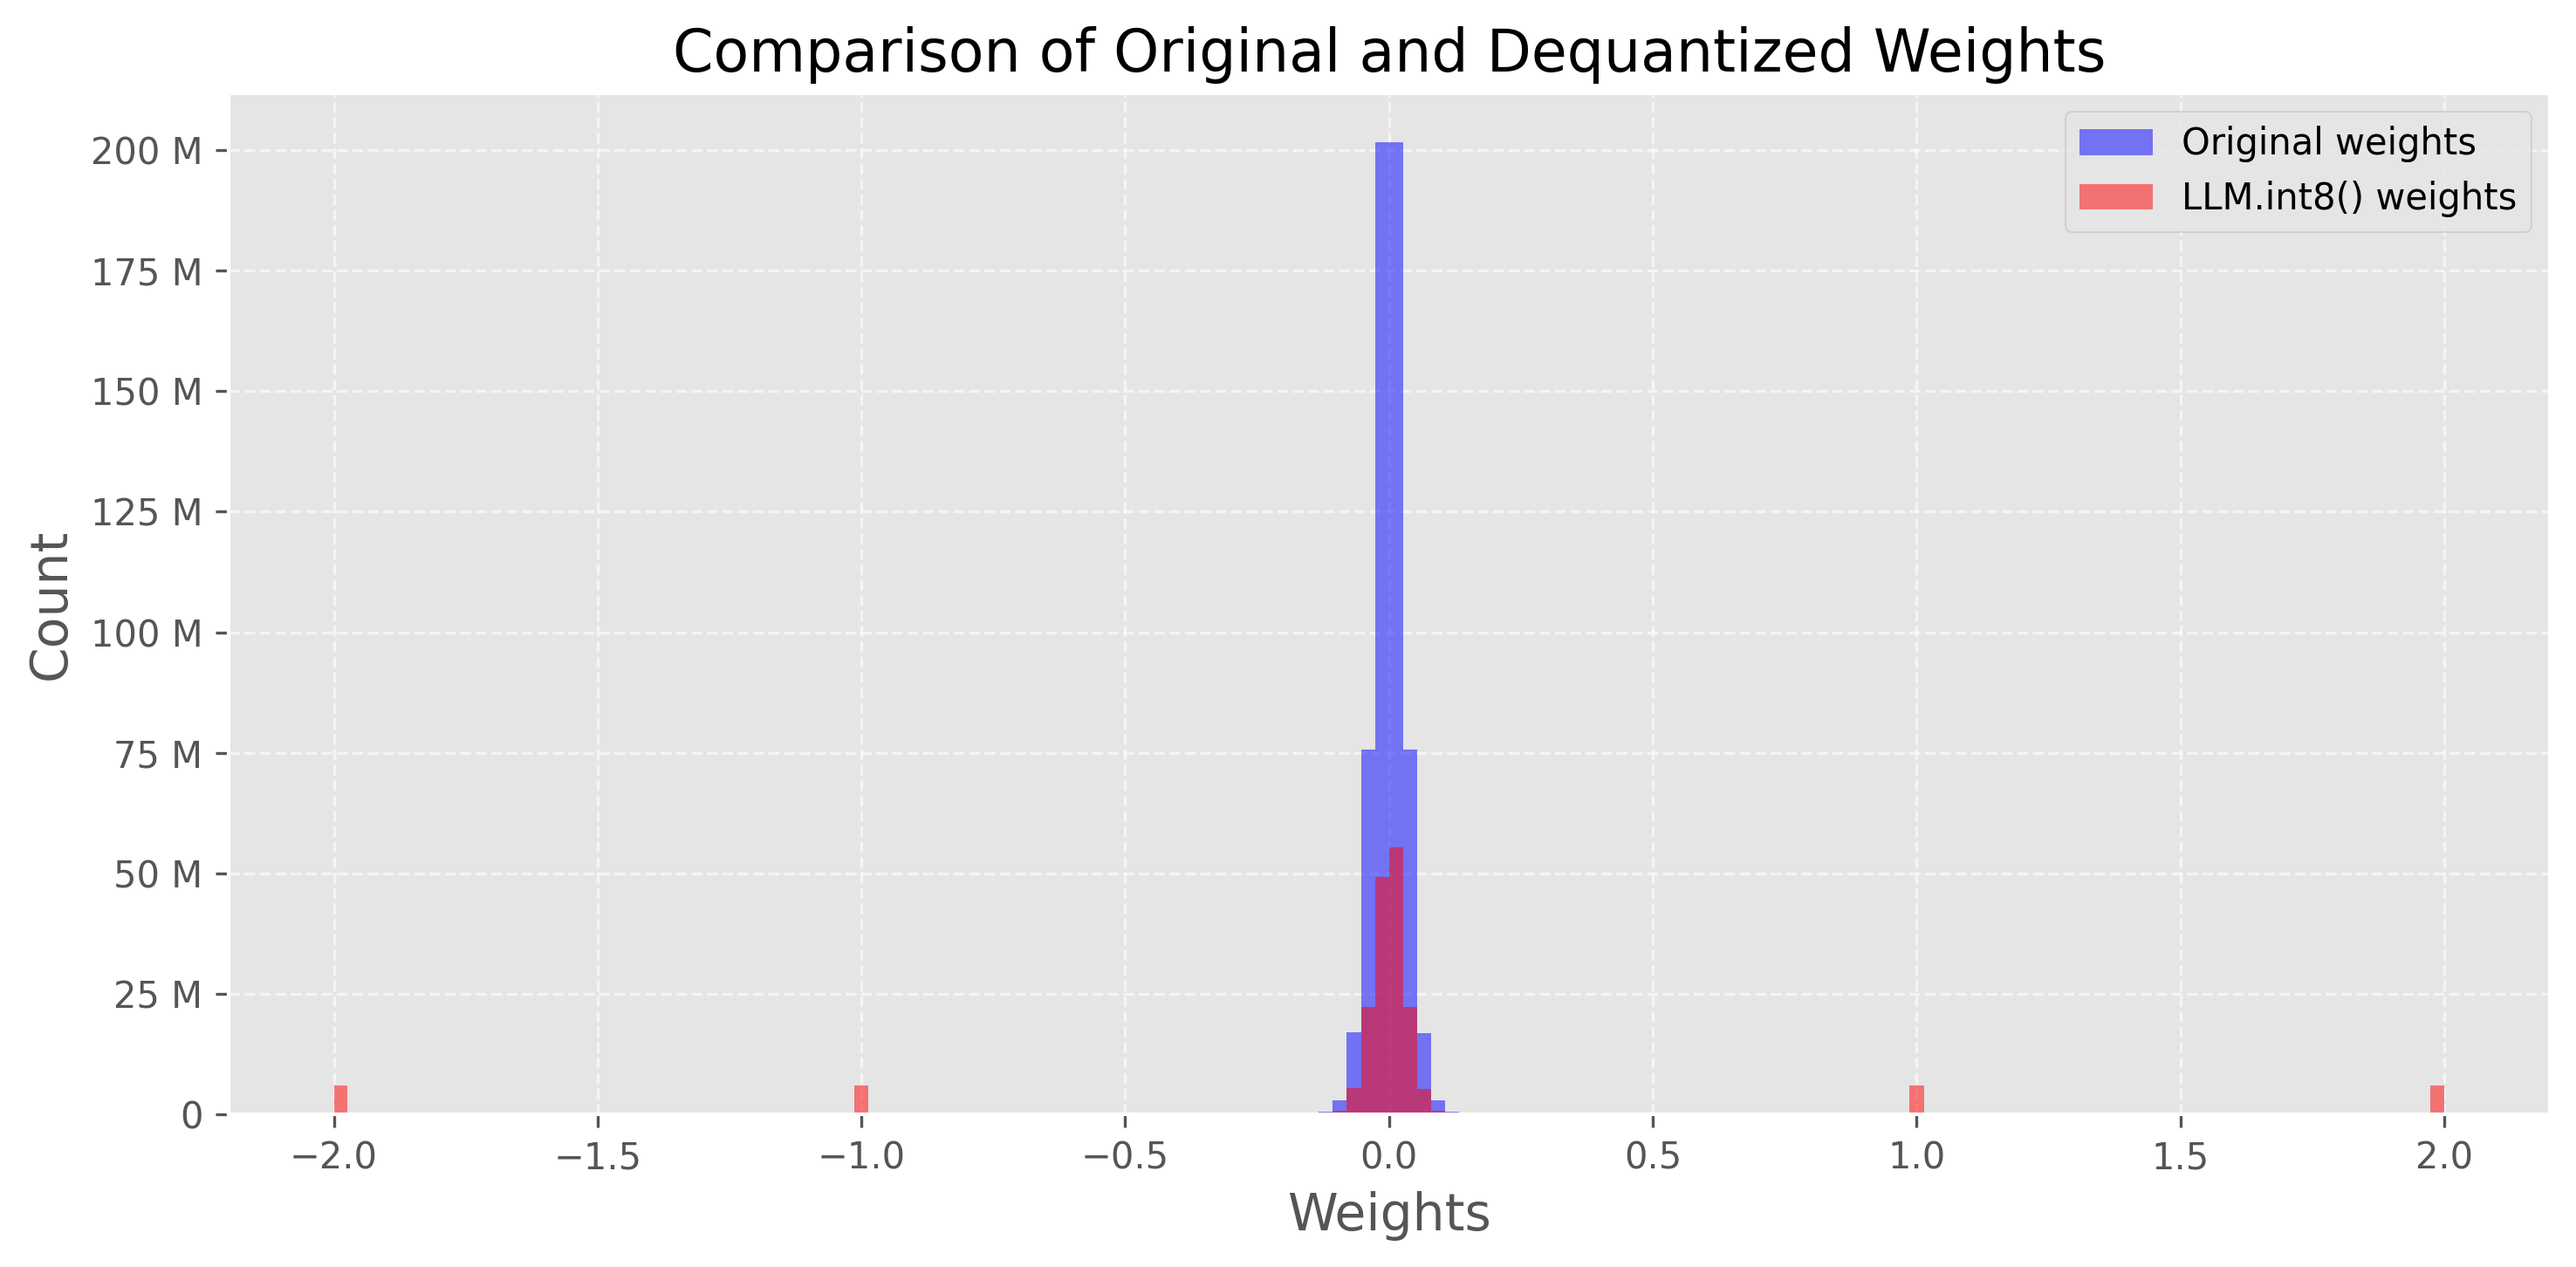

In [12]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Flatten weight tensors
weights_int8 = [param.data.clone() for param in model_int8.parameters()]
weights_int8 = torch.cat([t.flatten() for t in weights_int8]).cpu().numpy()

# Set background style
plt.style.use('ggplot')

# Create figure and axis
fig, ax = plt.subplots(figsize=(10,5), dpi=300)

# Plot the histograms
ax.hist(weights, bins=150, alpha=0.5, label='Original weights',
        color='blue', range=(-2, 2))
ax.hist(weights_int8, bins=150, alpha=0.5, label='LLM.int8() weights',
        color='red', range=(-2, 2))

# Add grid
ax.grid(True, linestyle='--', alpha=0.6)

# Add legend
ax.legend()

# Add title and labels
ax.set_title('Comparison of Original and Dequantized Weights', fontsize=16)
ax.set_xlabel('Weights', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
plt.gca().yaxis.set_major_formatter(ticker.EngFormatter())

# Improve font
plt.rc('font', size=12)

plt.tight_layout()
plt.show()

In [13]:
# Generate text with quantized model
text_int8 = generate_text(model_int8, "I have a dream")

print(f"Original model:\n{original_text}")
print("-" * 50)
print(f"LLM.int8() model:\n{text_int8}")

Original model:
I have a dream. The dream is of a world where the people who live on the land are not just people but beings who can walk on the moon and fly in space. These are the humans who will be able to create and sustain the Earth in the future. This dream is not just a utopian fantasy, but a reality that could be achieved if we work together to protect the environment and ensure that our future generations have access to the Earth as it is now.

Can you give me some more details about how
--------------------------------------------------
LLM.int8() model:
I have a dream. I have a dream. I am a dreamer. I dream about the future of my country. I dream about the future of our country. We should not forget our past. We should forget the mistakes made by the past generations. We should not forget the mistakes made by our ancestors. We should forget the mistakes made by our parents. We should forget the mistakes made by our teachers. We should forget the mistakes made by our classma

In [14]:
print(f"Perplexity (original):\t\t{ppl.item():.2f}")

ppl_int8 = calculate_perplexity(model_int8, original_text)
print(f"Absmax perplexity:\t\t{ppl_abs.item():.2f}")
print(f"Zeropoint perplexity:\t\t{ppl_zp.item():.2f}")
print(f"Perplexity (LLM.int8()):\t{ppl_int8.item():.2f}")

Perplexity (original):		5.23
Absmax perplexity:		5.88
Zeropoint perplexity:		5.96
Perplexity (LLM.int8()):	5.34
